# Deploying Flat-Bug

## Flat-bug setup

In [13]:
# Download the test image
from flat_bug import download_from_repository

image = "test_image.jpg"
download_from_repository(image)

# Import the main model class
from flat_bug.predictor import Predictor

# Optionally import the set_log_level function to control the verbosity of flat-bug module
# from flat_bug import set_log_level
# set_log_level("DEBUG") # default is "INFO"

## Basic Usage

In [ ]:
# Load the model
model = Predictor(device="cuda:0", dtype="float16")

# Predict
prediction = model(image)

for k, v in prediction.json_data.items():
    v = str(v)
    if len(v) > 100:
        v = v[:100] + "..."
    print(f"{k}: {v}")

YOLOv8m-seg summary (fused): 263 layers, 24,586,035 parameters, 0 gradients, 98.7 GFLOPs
boxes: [[2616, 1647, 2768, 1821], [915, 1589, 1107, 1803], [647, 1111, 977, 1279], [1900, 772, 2022, 920], ...
contours: [[[2707.33349609375, 2700.0, 2701.33349609375, 2703.33349609375, 2702.0, 2699.33349609375, 2691.3334...
confs: [0.95947265625, 0.95703125, 0.95361328125, 0.94873046875, 0.943359375, 0.93994140625, 0.93603515625,...
classes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
scales: [1.0, 1.0, 0.5949659166314774, 1.0, 1.0, 0.892448874947216, 0.892448874947216, 1.0, 1.0, 1.0, 1.0, 1...
image_path: test_image.jpg
image_width: 3840
image_height: 2160
mask_width: 3840
mask_height: 2160
identifier: None


## Plot results

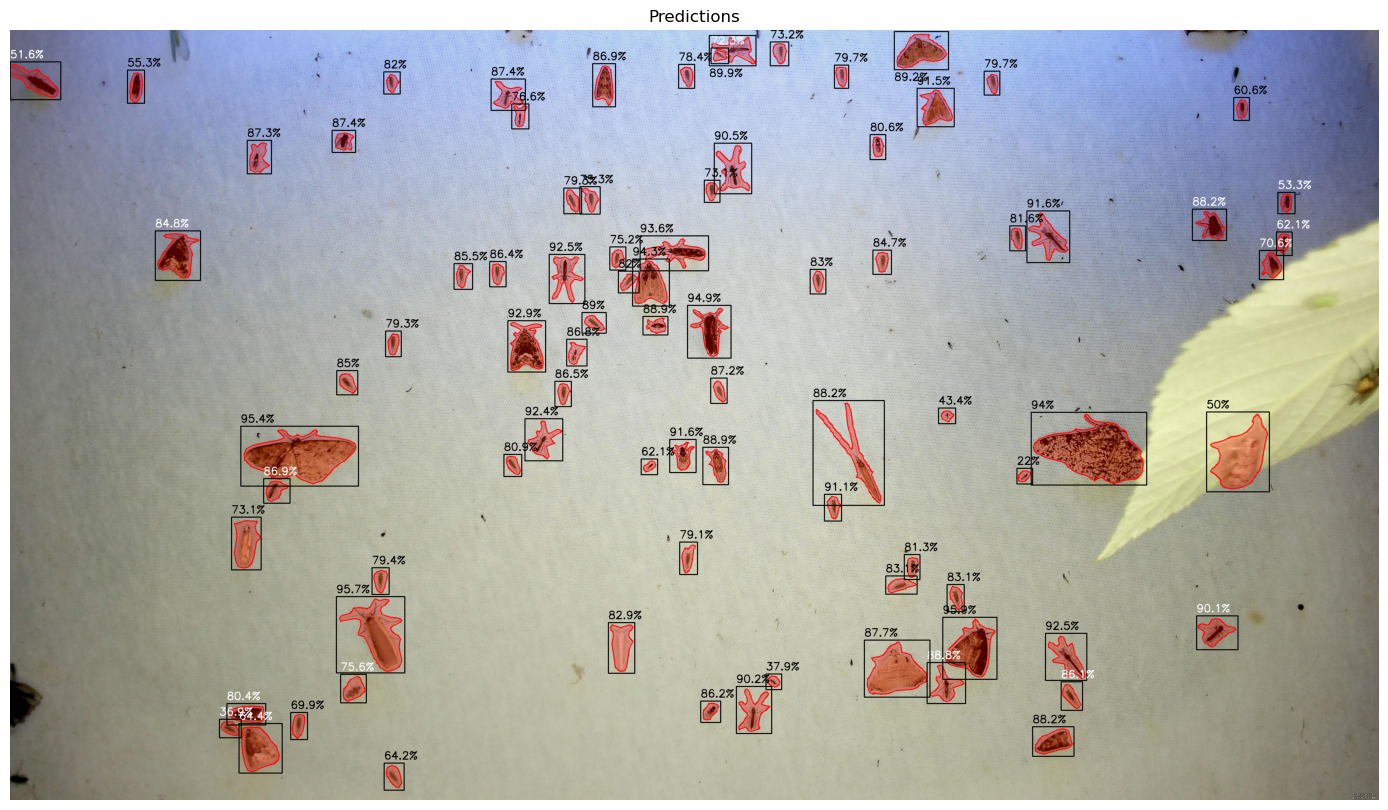

In [9]:
from matplotlib import pyplot as plt

# Plot all the predictions
plt.figure(figsize=(20, 10))
plt.imshow(prediction.plot())
plt.gca().axis("off")
plt.title("Predictions")
plt.show()

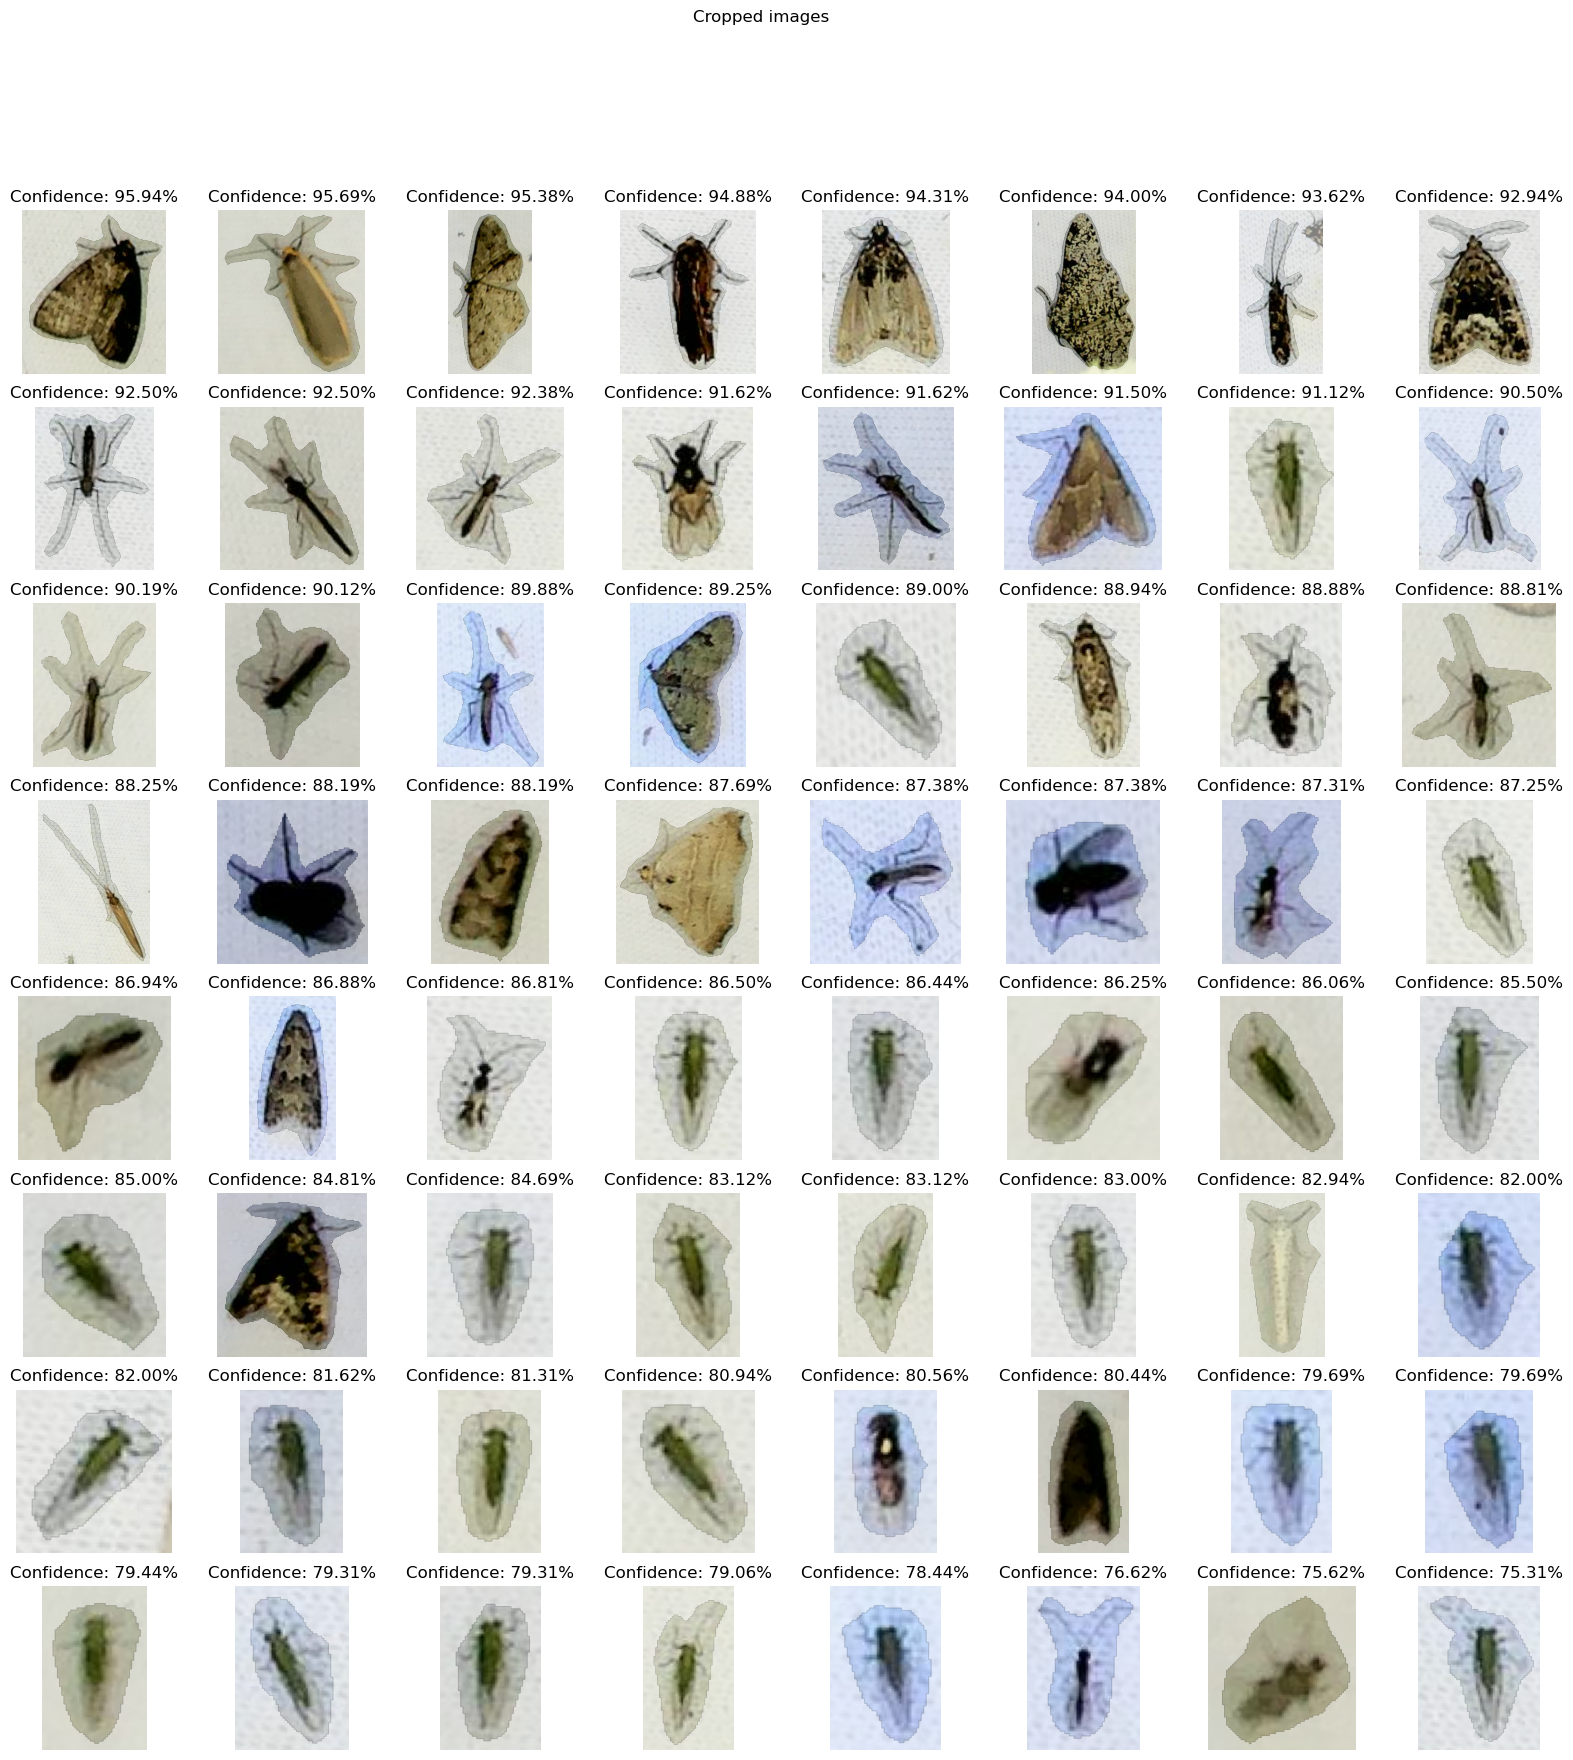

In [10]:
# Plot the cropped images
n_display = min(64, len(prediction))
crops, masks, confidences = prediction.crops[:n_display], prediction.crop_masks[:n_display], prediction.confs[:n_display]

n_crops = len(crops)
ncol = 8
nrow = n_crops // ncol
if n_crops % ncol:
    nrow += 1

fig, axs = plt.subplots(nrow, ncol, figsize=(2.5 * ncol, 2.5 * nrow))
axs = axs.flatten() if n_crops > 1 else [axs]
for ax, crop, mask, conf in zip(axs, crops, masks, confidences):
    crop = crop.permute(1, 2, 0).cpu()
    mask = 1 - mask.squeeze(0).cpu().float()
    w, h = mask.shape
    if w < h:
        mask = mask.transpose(1, 0)
        crop = crop.transpose(1, 0)
    ax.imshow(crop)
    ax.imshow(mask, cmap="gray", vmin=0, vmax=1, alpha=mask * 0.5) 
    ax.set_title(f"Confidence: {conf * 100:.2f}%")
    ax.axis("off")
plt.suptitle("Cropped images")
plt.show()

## Advanced Usage

## Hyperparameters

Timings using the default arguments


2024-11-13 18:18:41 - flat_bug - INFO - Prediction time: 0.480s/73.5% (overhead: 0.1) | Fetch 0.3% | Forward 60.4% | Postprocess 39.3%)
2024-11-13 18:18:41 - flat_bug - INFO - Prediction time: 0.419s/71.2% (overhead: 0.0) | Fetch 0.2% | Forward 55.9% | Postprocess 43.9%)
2024-11-13 18:18:42 - flat_bug - INFO - Prediction time: 0.257s/65.2% (overhead: 0.0) | Fetch 0.1% | Forward 45.9% | Postprocess 53.9%)
2024-11-13 18:18:42 - flat_bug - INFO - Prediction time: 0.076s/62.9% (overhead: 0.1) | Fetch 0.1% | Forward 38.1% | Postprocess 61.8%)
2024-11-13 18:18:42 - flat_bug - INFO - Prediction time: 0.018s/67.9% (overhead: 0.5) | Fetch 0.1% | Forward 60.4% | Postprocess 39.5%)
2024-11-13 18:18:42 - flat_bug - INFO - Total detection time: 1.783s (38.2% forward)
2024-11-13 18:18:42 - flat_bug - INFO - Combining 5 predictions into a single TensorPredictions object took 0.584 s | Duplication removal: 0.438 s | Mask combination: 0.101 s
2024-11-13 18:18:42 - flat_bug - INFO - Initializing TensorP

Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=True)


2024-11-13 18:18:45 - flat_bug - INFO - Prediction time: 0.084s/63.5% (overhead: 0.1) | Fetch 0.1% | Forward 40.8% | Postprocess 59.1%)
2024-11-13 18:18:45 - flat_bug - INFO - Total detection time: 0.133s (25.9% forward)
2024-11-13 18:18:45 - flat_bug - INFO - Combining 1 predictions into a single TensorPredictions object took 0.032 s | Duplication removal: 0.019 s | Mask combination: 0.009 s
2024-11-13 18:18:45 - flat_bug - INFO - Initializing TensorPredictions took 0.033 s
2024-11-13 18:18:45 - flat_bug - INFO - Offsetting, scaling and padding took 0.003 s
2024-11-13 18:18:45 - flat_bug - INFO - Non-maximum suppression took 0.052s for removing 34 elements of 70 elements
2024-11-13 18:18:45 - flat_bug - INFO - Total pyramid time: 0.397s (33.4% detection | 8.65% forward)


Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=False)


2024-11-13 18:18:46 - flat_bug - INFO - Prediction time: 0.188s/65.9% (overhead: 0.1) | Fetch 0.3% | Forward 48.2% | Postprocess 51.6%)
2024-11-13 18:18:46 - flat_bug - INFO - Prediction time: 0.076s/63.8% (overhead: 0.1) | Fetch 0.1% | Forward 40.5% | Postprocess 59.4%)
2024-11-13 18:18:46 - flat_bug - INFO - Prediction time: 0.018s/72.4% (overhead: 0.4) | Fetch 0.1% | Forward 62.7% | Postprocess 37.1%)
2024-11-13 18:18:46 - flat_bug - INFO - Total detection time: 0.429s (30.9% forward)
2024-11-13 18:18:46 - flat_bug - INFO - Combining 3 predictions into a single TensorPredictions object took 0.098 s | Duplication removal: 0.059 s | Mask combination: 0.027 s
2024-11-13 18:18:46 - flat_bug - INFO - Initializing TensorPredictions took 0.099 s
2024-11-13 18:18:46 - flat_bug - INFO - Offsetting, scaling and padding took 0.006 s
2024-11-13 18:18:47 - flat_bug - INFO - Non-maximum suppression took 0.269s for removing 181 elements of 223 elements
2024-11-13 18:18:47 - flat_bug - INFO - Total

Timings after manually overriding the pyramid_predictions arguments (scale_before=0.266, single_scale=False)


2024-11-13 18:18:48 - flat_bug - INFO - Prediction time: 0.116s/88.9% (overhead: 0.1) | Fetch 0.1% | Forward 86.4% | Postprocess 13.5%)
2024-11-13 18:18:48 - flat_bug - INFO - Total detection time: 0.130s (76.7% forward)
2024-11-13 18:18:48 - flat_bug - INFO - Combining 1 predictions into a single TensorPredictions object took 0.011 s | Duplication removal: 0.006 s | Mask combination: 0.003 s
2024-11-13 18:18:48 - flat_bug - INFO - Initializing TensorPredictions took 0.011 s
2024-11-13 18:18:48 - flat_bug - INFO - Offsetting, scaling and padding took 0.001 s
2024-11-13 18:18:48 - flat_bug - INFO - Non-maximum suppression took 0.454s for removing 9 elements of 21 elements
2024-11-13 18:18:48 - flat_bug - INFO - Total pyramid time: 0.695s (18.8% detection | 14.4% forward)


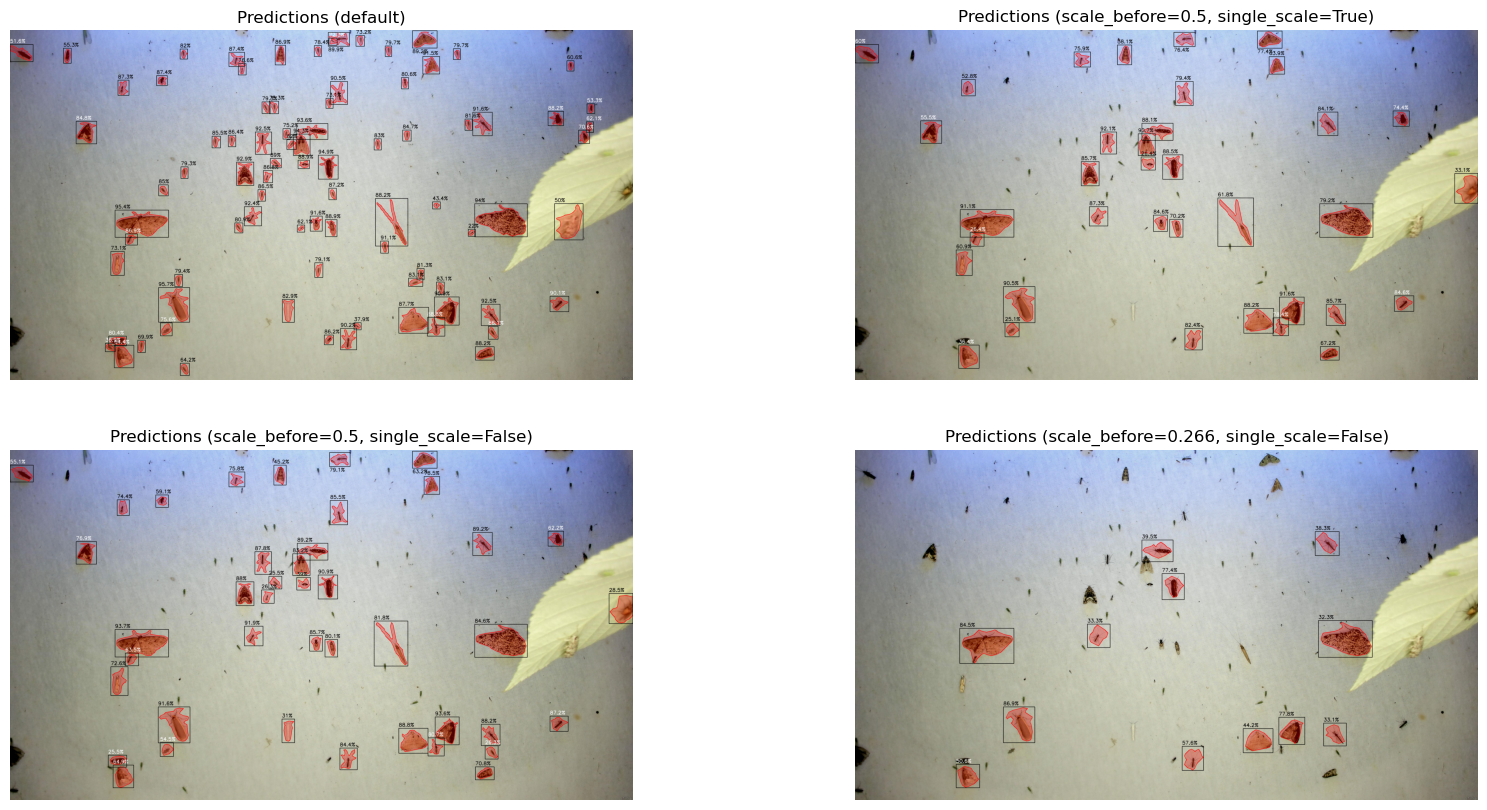

In [12]:
# We can set the model hyperparameters after loading the model with the set_hyperparameters method
model.set_hyperparameters(
    TIME = True,
    # IOU_THRESHOLD, etc. see the documentation for more options
)

# Here I will demonstrate how to use the pyramid_predictions method with custom arguments and compare the timings and results
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

# Predict with defaults
print("Timings using the default arguments")
axs[0].imshow(model.pyramid_predictions(image).plot()) # Default arguments (scale_before=1.0, single_scale=False)
axs[0].axis("off")
axs[0].set_title("Predictions (default)")

# Predict with custom arguments
print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=True)")
axs[1].imshow(model.pyramid_predictions(image, scale_before=0.5, single_scale=True).plot()) # Scale the image down by 50% and only predict at the native level
axs[1].axis("off")
axs[1].set_title("Predictions (scale_before=0.5, single_scale=True)")

print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=False)")
axs[2].imshow(model.pyramid_predictions(image, scale_before=0.5, single_scale=False).plot()) # Scale the image down by 50% and tile from there
axs[2].axis("off")
axs[2].set_title("Predictions (scale_before=0.5, single_scale=False)")

print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.266, single_scale=False)") # Scale the image down such that the largest dimension is smaller than the tile size (1024)
axs[3].imshow(model.pyramid_predictions(image, scale_before=0.266, single_scale=False).plot()) # Scale the image down such that the largest dimension is smaller than the tile size (1024)
axs[3].axis("off")
axs[3].set_title("Predictions (scale_before=0.266, single_scale=False)")

# Show plot
plt.show()